In [1]:
import os
import time
import sys
import matplotlib.pyplot as plt
import numpy as np 
import matplotlib.cm as cm
import matplotlib.image as plimg
import scipy.ndimage.interpolation as spndint
def showError(message):
        raise Exception(message)


Read Antenna Function

In [2]:
cur_dir = os.getcwd()
model_dir = os.path.join(cur_dir, 'SOURCE_MODELS')
antenna_dir = os.path.join(cur_dir, 'ARRAYS')
data_dir = os.path.join(cur_dir, 'PICTURES')
array_name = 'VLA-A.array'
model_name = 'Faceon-Galaxy.model'

antenna_file = os.path.join(antenna_dir, array_name)
Hfac = np.pi / 180. * 15.
deg2rad = np.pi / 180.
curzoom = [0, 0, 0, 0]
robust = 0.0
deltaAng = 1. * deg2rad
gamma = 0.5
lfac = 1.e6 
ulab = r'U (M$\lambda$)'
vlab = r'V (M$\lambda$)'
nH = 200
Npix = 512
Hcov = [-12.0 * Hfac, 12.0 * Hfac]
Hmax = np.pi
lat = 45. * deg2rad
dec = 60. * deg2rad
trlat = [np.sin(lat), np.cos(lat)]
trdec = [np.sin(dec), np.cos(dec)]
Xmax = 4.0
Diameters = [0., 0.]
wavelength = [3.e-6, 21.e-5, 6.e-5]  # in km.
antPos = []
Hcov = [0, 0]
Nant = 0
fi = open(antenna_file)
for li, l in enumerate(fi.readlines()):
    comm = l.find('#')
    if comm >= 0:
        l = l[:comm]
    it = l.split()
    if len(it) > 0:
        if it[0] == 'WAVELENGTH':
            wavelength = [
                float(it[1]) * 1.e-3,
                float(it[2]) * 1.e-3
            ]
            wavelength.append(
                (wavelength[0] + wavelength[1]) / 2.)
        elif it[0] == 'ANTENNA':
                            antPos.append(list(map(float, it[1:])))
                            Nant += 1
                            antPos[-1][0] *= 1.e-3
                            antPos[-1][1] *= 1.e-3
                            Xmax = np.max(np.abs(antPos[-1] + [Xmax]))
        elif it[0] == 'DIAMETER':
            Diams = list(map(float, it[1:]))
            Diameters[0] = Diams[0]
            if len(Diams) > 1:
                Diameters[1] = Diams[1]
        elif it[0] == 'LATITUDE':
            lat = float(it[1]) * deg2rad
            trlat = [np.sin(lat), np.cos(lat)]
        elif it[0] == 'DECLINATION':
            dec = float(it[1]) * deg2rad
            trdec = [np.sin(dec), np.cos(dec)]
        elif it[0] == 'HOUR_ANGLE':
            Hcov[0] = float(it[1]) * Hfac
            Hcov[1] = float(it[2]) * Hfac
cosW = -np.tan(lat) * np.tan(dec)
if np.abs(cosW) < 1.0:
    Hhor = np.arccos(cosW)
elif np.abs(lat - dec) > np.pi / 2.:
    Hhor = 0
else:
    Hhor = np.pi

if Hhor > 0.0:
    if Hcov[0] < -Hhor:
        Hcov[0] = -Hhor
    if Hcov[1] > Hhor:
        Hcov[1] = Hhor

Hmax = Hhor
H = np.linspace(Hcov[0], Hcov[1],
                nH)[np.newaxis, :]
Xmax = Xmax * 1.5  
fi.close()      

Read Model Function 

In [3]:
model_file = os.path.join(model_dir, model_name)
imsize = 4.
fixsize = False
models = []
imfiles = []
Xmax = 0.0
fi = open(model_file)
for li, l in enumerate(fi.readlines()):
    comm = l.find('#')
    if comm >= 0:
        l = l[:comm]
    it = l.split()
    if len(it) > 0:
        if it[0] == 'IMAGE':
            imfiles.append([str(it[1]), float(it[2])])
        elif it[0] in ['G', 'D', 'P']:
            models.append([it[0]] + list(map(float, it[1:])))
            if models[-1][0] != 'P':
                models[-1][4] = np.abs(models[-1][4])
                Xmax = np.max([
                    np.abs(models[-1][1]) + models[-1][4],
                    np.abs(models[-1][2]) + models[-1][4], Xmax
                ])
        elif it[0] == 'IMSIZE':
            imsize = 2. * float(it[1])
            fixsize = True
        else:
            showError(
                "\n\nWRONG SYNTAX IN LINE %i:\n\n %s...\n\n" %
                (li + 1, l[:max(10, len(l))]))

if len(models) + len(imfiles) == 0:
    showError(
        "\n\nThere should be at least 1 model component!\n\n")

models = models
imsize = imsize
imfiles = imfiles

if not fixsize:
    imsize = Xmax * 1.1

Xaxmax = imsize / 2.

fi.close()

print(models)
print(imfiles)

[]
[['M100-v2.png', 1.0]]


Variable Initialization at the beginnining of GUI

In [4]:
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = 10 * np.outer(np.cos(u), np.sin(v))
y = 10 * np.outer(np.sin(u), np.sin(v))
z = 10 * np.outer(np.ones(np.size(u)), np.cos(v))
beta = np.zeros(100)
arrayPath = [
    np.zeros(nH),
    np.zeros(nH),
    np.zeros(nH)
]


currcmap = cm.jet
fmtH = r'$\phi = $ %3.1f$^\circ$   $\delta = $ %3.1f$^\circ$' "\n" r'H = %3.1fh / %3.1fh'
fmtBas = r'Bas %i $-$ %i  at  H = %4.2fh'
fmtVis = r'Amp: %.1e Jy.   Phase: %5.1f deg.'
fmtA = 'N = %i'
fmtA2 = '  Picked Ant. #%i'
fmtA3 = '\n%6.1fm | %6.1fm'
fmtB1 = r'$\lambda = $ %4.1fmm  ' % (wavelength[2] * 1.e6)
fmtB = fmtB1 + "\n" + r'% 4.2f Jy/beam' + "\n" + r'$\Delta\alpha = $ % 4.2f / $\Delta\delta = $ % 4.2f '
fmtD = r'% .2e Jy/beam' "\n" r'$\Delta\alpha = $ % 4.2f / $\Delta\delta = $ % 4.2f '
fmtM = r'%.2e Jy/pixel' "\n" r'$\Delta\alpha = $ % 4.2f / $\Delta\delta = $ % 4.2f'

In [5]:


Nphf = Npix // 2
robfac = 0.0
W2W1 = 1

Prepare Beam Function 

In [6]:
beam = np.zeros((Npix, Npix), dtype=np.float32)
totsampling = np.zeros((Npix, Npix), dtype=np.float32)
dirtymap = np.zeros((Npix, Npix), dtype=np.float32)
noisemap = np.zeros((Npix, Npix), dtype=np.complex64)
robustsamp = np.zeros((Npix, Npix), dtype=np.float32)
Gsampling = np.zeros((Npix, Npix), dtype=np.complex64)
Grobustsamp = np.zeros((Npix, Npix), dtype=np.complex64)
GrobustNoise = np.zeros((Npix, Npix),dtype=np.complex64)
beam2 = np.zeros((Npix, Npix), dtype=np.float32)
totsampling2 = np.zeros((Npix, Npix), dtype=np.float32)
dirtymap2 = np.zeros((Npix, Npix), dtype=np.float32)
robustsamp2 = np.zeros((Npix, Npix), dtype=np.float32)

Prepare Baseline Function 

In [7]:
Nbas = Nant * (Nant - 1) // 2
NBmax = Nbas
B = np.zeros((NBmax, nH), dtype=np.float32)
basnum = np.zeros((Nant, Nant - 1), dtype=np.int8)
basidx = np.zeros((Nant, Nant), dtype=np.int8)
antnum = np.zeros((NBmax, 2), dtype=np.int8)
Gains = np.ones((Nbas, nH), dtype=np.complex64)
Noise = np.zeros((Nbas, nH), dtype=np.complex64)
Horig = np.linspace(Hcov[0], Hcov[1], nH)
H = Horig[np.newaxis, :]
H = [np.sin(H), np.cos(H)]
bi = 0
nii = [0 for n in range(Nant)]
for n1 in range(Nant - 1):
    for n2 in range(n1 + 1, Nant):
        basnum[n1, nii[n1]] = np.int8(bi)
        basnum[n2, nii[n2]] = np.int8(bi)
        basidx[n1, n2] = np.int8(bi)
        antnum[bi] = [n1, n2]
        nii[n1] += 1
        nii[n2] += 1
        bi += np.int8(1)
u = np.zeros((NBmax, nH))
v = np.zeros((NBmax, nH))
ravelDims = (NBmax, nH)

Set Baselines Function 

In [8]:
antidx = -1 
if antidx == -1:
        bas2change = range(Nbas)
elif antidx < Nant:
    bas2change = basnum[antidx].flatten()
else:
    bas2change = []
for currBas in bas2change:
    n1, n2 = antnum[currBas]
    B[currBas, 0] = -(antPos[n2][1] - antPos[n1][1]) \
                         * trlat[0] / wavelength[2]
    B[currBas, 1] = (antPos[n2][0] - antPos[n1][0]) \
                         / wavelength[2]
    B[currBas, 2] = (antPos[n2][1] - antPos[n1][1]) \
                         * trlat[1] / wavelength[2]
    u[currBas, :] = -(B[currBas, 0] * H[0] + B[currBas, 1] * H[1])
    v[currBas, :] = -B[currBas, 0] * trdec[0] * H[1] \
                         + B[currBas, 1] * trdec[0] * H[0] \
                         + trdec[1] * B[currBas, 2]

Grid UV Function 

In [9]:
if antidx == -1:
    bas2change = range(Nbas)
    pixpos = [[] for nb in bas2change]
    totsampling[:] = 0.0
    Gsampling[:] = 0.0
    noisemap[:] = 0.0
elif antidx < Nant:
    bas2change = list(map(int, list(basnum[antidx].flatten())))
else:
    bas2change = []
UVpixsize = 2. / (imsize * np.pi / 180. / 3600.)
for nb in bas2change:
    pixU = np.rint(u[nb] / UVpixsize).flatten().astype(
        np.int32)
    pixV = np.rint(v[nb] / UVpixsize).flatten().astype(
        np.int32)
    goodpix = np.where(
        np.logical_and(
            np.abs(pixU) < Nphf,
            np.abs(pixV) < Nphf))[0]
    pU = pixU[goodpix] + Nphf
    pV = pixV[goodpix] + Nphf
    mU = -pixU[goodpix] + Nphf
    mV = -pixV[goodpix] + Nphf
    if antidx != -1:
        totsampling[pixpos[nb][1], pixpos[nb][2]] -= 1.0
        totsampling[pixpos[nb][3], pixpos[nb][0]] -= 1.0
        Gsampling[pixpos[nb][1], 
                       pixpos[nb][2]] -= Gains[nb, goodpix]
        Gsampling[pixpos[nb][3], 
                       pixpos[nb][0]] -= np.conjugate(
                           Gains[nb, goodpix])
        noisemap[pixpos[nb][1], pixpos[nb]
                      [2]] -= Noise[nb, goodpix] * np.abs(
                          Gains[nb, goodpix])
        noisemap[pixpos[nb][3], 
                      pixpos[nb][0]] -= np.conjugate(
                          Noise[nb, goodpix]) * np.abs(
                              Gains[nb, goodpix])
    pixpos[nb] = [
        np.copy(pU),
        np.copy(pV),
        np.copy(mU),
        np.copy(mV)
    ]
    for pi, gp in enumerate(goodpix):
        gabs = np.abs(Gains[nb, gp])
        pVi = pV[pi]
        mUi = mU[pi]
        mVi = mV[pi]
        pUi = pU[pi]
        totsampling[pVi, mUi] += 1.0
        totsampling[mVi, pUi] += 1.0
        Gsampling[pVi, mUi] += Gains[nb, gp]
        Gsampling[mVi, pUi] += np.conjugate(Gains[nb, gp])
        noisemap[pVi, mUi] += Noise[nb, gp] * gabs
        noisemap[mVi, pUi] += np.conjugate(
            Noise[nb, gp]) * gabs
robfac = (5. * 10.**(-robust))**2. * (
    2. * Nbas * nH) / np.sum(totsampling**2.)


Set Beam Function (be aware that the first line of this function would be gridUV function)

In [10]:

denom = 1. + robfac * totsampling
robustsamp[:] = totsampling / denom
Grobustsamp[:] = Gsampling / denom
GrobustNoise[:] = noisemap / denom
beam[:] = np.fft.ifftshift(
    np.fft.ifft2(np.fft.fftshift(
        robustsamp))).real / (1. + W2W1)
beamScale = np.max(beam[Nphf:Nphf +1, Nphf:Nphf + 1])
beam[:] /= beamScale

Plot Beam Function 

140400.0
1572.0


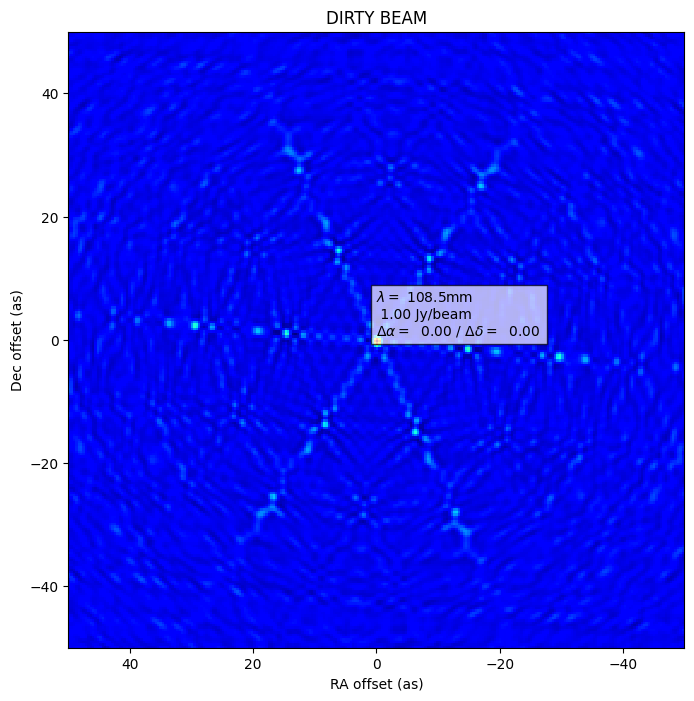

In [11]:
Np4 = Npix // 4
beamPlot = plt.figure(figsize=(8, 8))
beamPlotPlot = plt.imshow(
    beam[Np4:Npix - Np4, Np4:Npix - Np4],
    picker=True,
    interpolation='nearest',
    cmap=currcmap)
beamText = plt.text(
    0.05,
    0.80,
    fmtB % (1.0, 0.0, 0.0),
    bbox=dict(facecolor='white', alpha=0.7))
plt.ylabel('Dec offset (as)')
plt.xlabel('RA offset (as)')
plt.setp(beamPlotPlot,
        extent=(Xaxmax / 2., -Xaxmax / 2.,
                -Xaxmax / 2., Xaxmax / 2.))
curzoom[0] = (Xaxmax / 2., -Xaxmax / 2.,
                   -Xaxmax / 2., Xaxmax / 2.)
plt.title('DIRTY BEAM')
nptot = np.sum(totsampling[:])
beamPlotPlot.norm.vmin = np.min(beam)
beamPlotPlot.norm.vmax = 1.0
print(nptot)
print(np.sum(totsampling[Nphf - 4:Nphf + 4, Nphf -
                           4:Nphf + 4]))
if np.sum(totsampling[Nphf - 4:Nphf + 4, Nphf -
                           4:Nphf + 4]) == nptot:
    warn = 'WARNING!\nToo short baselines for such a small image\nPLEASE, INCREASE THE IMAGE SIZE!\nAND/OR DECREASE THE WAVELENGTH'
    beamText.set_text(warn)
arrayPath[0][:] = 10. * H[1] * np.cos(lat)
arrayPath[1][:] = 10. * H[0] * np.cos(lat)
arrayPath[2][:] = 10. * np.sin(lat)

plt.show()


Plot Antennas


/var/folders/66/76q50s015tq8wc5qz1pvg7y40000gn/T/ipykernel_75310/43375528.py:19: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(-Xmax, Xmax)
/var/folders/66/76q50s015tq8wc5qz1pvg7y40000gn/T/ipykernel_75310/43375528.py:20: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(-Xmax, Xmax)


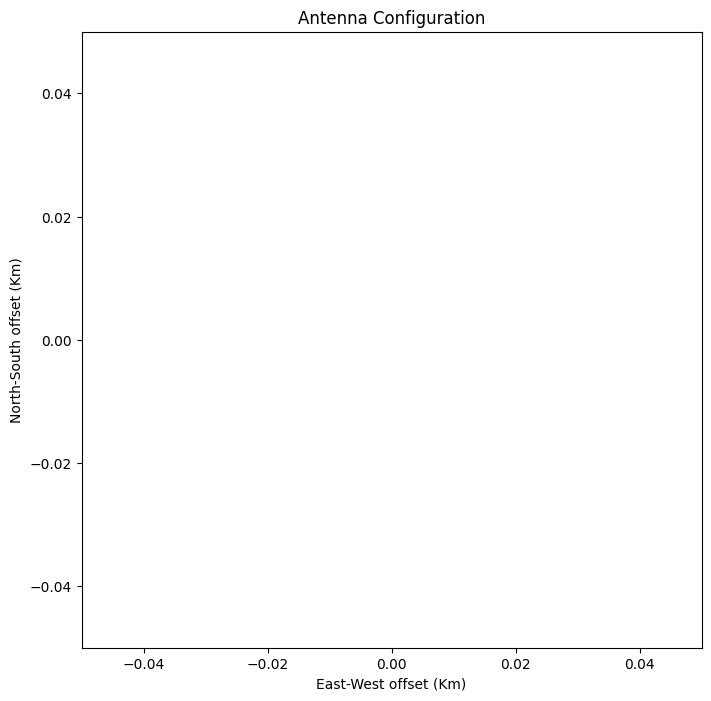

-0.0 0.0


/var/folders/66/76q50s015tq8wc5qz1pvg7y40000gn/T/ipykernel_75310/43375528.py:45: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim((2. * Xmax / wavelength[2] / lfac,
/var/folders/66/76q50s015tq8wc5qz1pvg7y40000gn/T/ipykernel_75310/43375528.py:47: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim((2. * Xmax / wavelength[2] / lfac,


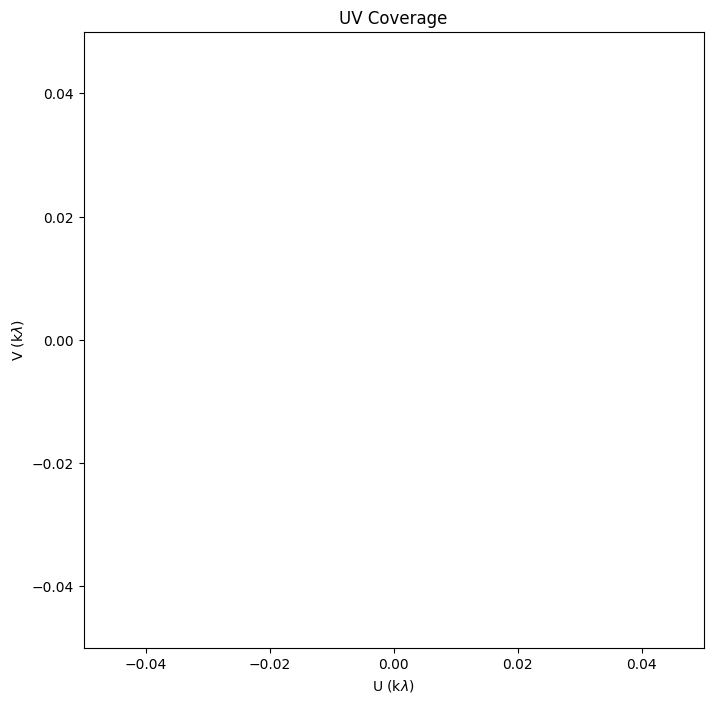

In [18]:
antPlot = plt.figure(figsize=(8, 8))
mw = 2. * Xmax / wavelength[2] / lfac
if mw < 0.1 and lfac == 1.e6:
    lfac = 1.e3
    ulab = r'U (k$\lambda$)'
    vlab = r'V (k$\lambda$)'
elif mw >= 100. and lfac == 1.e3:
    lfac = 1.e6
    ulab = r'U (M$\lambda$)'
    vlab = r'V (M$\lambda$)'
toplot = np.array(antPos[:Nant])
antPlotBas = plt.plot([0], [0], '-b')[0]
antPlotPlot = plt.plot(toplot[:, 0], toplot[:, 1],
                                            'o',
                                            color='lime',
                                            picker=5)[0]


plt.xlim(-Xmax, Xmax)
plt.ylim(-Xmax, Xmax)
plt.xlabel('East-West offset (Km)')
plt.ylabel('North-South offset (Km)')
plt.title('Antenna Configuration')
plt.show()
print(-Xmax, Xmax)

UVPlot = plt.figure(figsize=(8, 8))
UVPlotPlot = []
toplotu = u.flatten() / lfac
toplotv = v.flatten() / lfac
UVPlotPlot.append(
    plt.plot(toplotu,
                     toplotv,
                     '.',
                     color='lime',
                     markersize=1,
                     picker=2)[0])
UVPlotPlot.append(
    plt.plot(-toplotu,
                     -toplotv,
                     '.',
                     color='lime',
                     markersize=1,
                     picker=2)[0])
plt.xlim((2. * Xmax / wavelength[2] / lfac,
                 -2. * Xmax / wavelength[2] / lfac))
plt.ylim((2. * Xmax / wavelength[2] / lfac,
                 -2. * Xmax / wavelength[2] / lfac))
plt.xlabel(ulab)
plt.ylabel(vlab)
plt.title('UV Coverage')
plt.show()

Prepare Model Function 

In [13]:
pixsize = float(imsize) / Npix
xx = np.linspace(-imsize / 2., imsize / 2., Npix)
yy = np.ones(Npix, dtype=np.float32)
distmat = np.zeros((Npix, Npix), dtype=np.float32)
modelim = [np.zeros((Npix, Npix), dtype=np.float32) for i in [0, 1]]
modelimTrue = np.zeros((Npix, Npix), dtype=np.float32)
for model in models:
    xsh = -model[1]
    ysh = -model[2]
    xpix = np.rint(xsh / pixsize).astype(np.int32)
    ypix = np.rint(ysh / pixsize).astype(np.int32)
    centy = np.roll(xx, ypix)
    centx = np.roll(xx, xpix)
    distmat[:] = np.outer(centy**2., yy) + np.outer(yy, centx**2.)
    if model[0] == 'D':
        mask = np.logical_or(distmat <= model[4]**2.,
                             distmat == np.min(distmat))
        modelimTrue[mask] += float(model[3]) / np.sum(mask)
    elif model[0] == 'G':
        gauss = np.exp(-distmat / (2. * model[4]**2.))
        modelimTrue[:] += float(model[3]) * gauss / np.sum(gauss)
    elif model[0] == 'P':
        if np.abs(xpix + Nphf) < Npix and np.abs(
                ypix + Nphf) < Npix:
            yint = ypix + Nphf
            xint = xpix + Nphf
            modelimTrue[yint, xint] += float(model[3])
for imfile in imfiles:
    if not os.path.exists(imfile[0]):
        imfile[0] = os.path.join(data_dir, imfile[0])
        if not os.path.exists(imfile[0]):
            showError(message=
                'File %s does NOT exist. Cannot read the model!' %
                imfile[0])
    Np4 = Npix // 4
    img = plimg.imread(imfile[0]).astype(np.float32)
    dims = np.shape(img)
    d3 = min(2, dims[2])
    d1 = float(max(dims))
    avimg = np.average(img[:, :, :d3], axis=2)
    avimg -= np.min(avimg)
    avimg *= imfile[1] / np.max(avimg)
    if d1 == Nphf:
        sh0 = (Nphf - dims[0]) // 2
        sh1 = (Nphf - dims[1]) // 2
        modelimTrue[sh0 + Np4:sh0 + Np4 + dims[0], sh1 + Np4:sh1 +
                         Np4 + dims[1]] += zoomimg
    else:
        zoomimg = spndint.zoom(avimg, float(Nphf) / d1)
        zdims = np.shape(zoomimg)
        zd0 = min(zdims[0], Nphf)
        zd1 = min(zdims[1], Nphf)
        sh0 = (Nphf - zdims[0]) // 2
        sh1 = (Nphf - zdims[1]) // 2
        modelimTrue[sh0 + Np4:sh0 + Np4 + zd0, sh1 + Np4:sh1 +
                         Np4 + zd1] += zoomimg[:zd0, :zd1]

modelimTrue[modelimTrue < 0.0] = 0.0
xx = np.linspace(-imsize / 2., imsize / 2., Npix)
yy = np.ones(Npix, dtype=np.float32)
distmat = (-np.outer(xx**2., yy) -
                np.outer(yy, xx**2.)) * pixsize**2.

# here the setPrimaryBeam Function runs
# _setPrimaryBeam(replotFFT=True)

/var/folders/66/76q50s015tq8wc5qz1pvg7y40000gn/T/ipykernel_75310/1398264852.py:49: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  zoomimg = spndint.zoom(avimg, float(Nphf) / d1)


Set Primary Beam Function 

In [14]:
if Diameters[0] > 0.0:
    PB = 2. * (1220. * 180. / np.pi * 3600. * wavelength[2] /
               Diameters[0] / 2.3548)**2.
    beamImg = np.exp(distmat / PB)
    modelim[0][:] = modelimTrue * beamImg
else:
    modelim[0][:] = modelimTrue
modelfft = np.fft.fft2(np.fft.fftshift(modelim[0]))
modelfft2 = np.fft.fft2(np.fft.fftshift(modelim[1]))

Plot Model Function 

Text(0.5, 1.0, 'MODEL IMAGE: 7.94e+03 Jy')

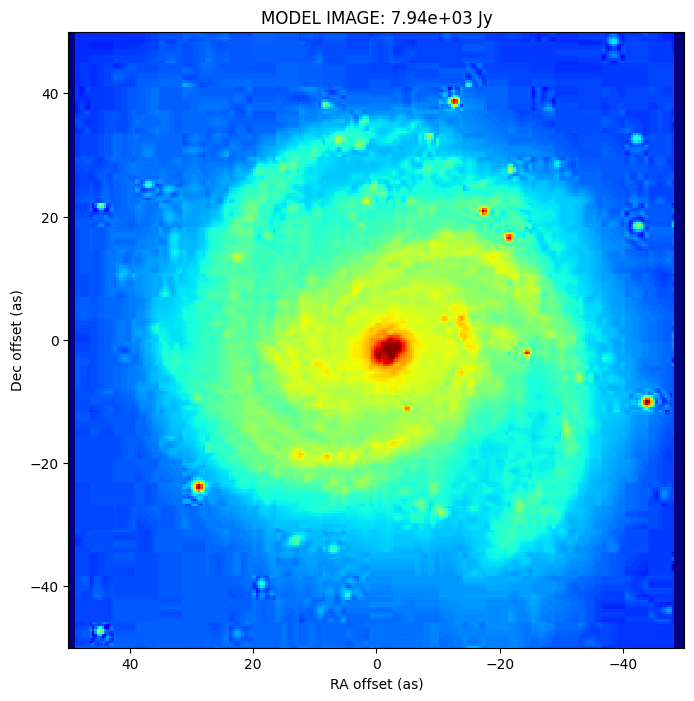

In [15]:
Np4 = Npix // 4
modelPlot = plt.figure(figsize=(8, 8))
modelPlotPlot = plt.imshow(
    np.power(
        modelimTrue[Np4:Npix - Np4, Np4:Npix - Np4],
        gamma),
    picker=True,
    interpolation='nearest',
    vmin=0.0,
    vmax=np.max(modelimTrue)**gamma,
    cmap=currcmap)

modflux = modelimTrue[Nphf, Nphf]
plt.setp(modelPlotPlot,
        extent=(Xaxmax / 2., -Xaxmax / 2.,
                -Xaxmax / 2., Xaxmax / 2.))
plt.ylabel('Dec offset (as)')
plt.xlabel('RA offset (as)')
totflux = np.sum(modelimTrue[Np4:Npix -Np4, Np4:Npix - Np4])
plt.title('MODEL IMAGE: %.2e Jy' % totflux)

Plot Dirty Function

Text(0.5, 1.0, 'DIRTY IMAGE')

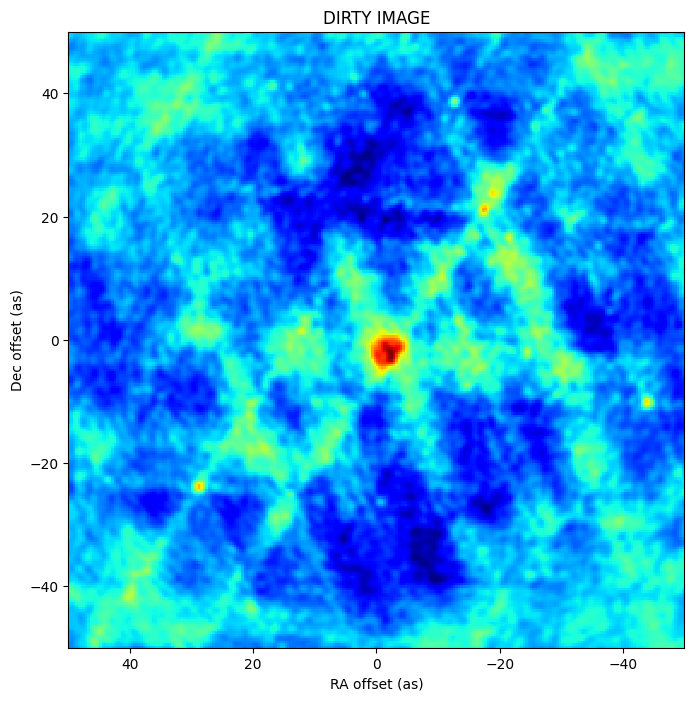

In [16]:
dirtyPlot = plt.figure(figsize=(8, 8))
Np4 = Npix // 4
dirtymap[:] = (np.fft.fftshift(
    np.fft.ifft2(
        np.fft.ifftshift(GrobustNoise) + modelfft *
        np.fft.ifftshift(Grobustsamp)))).real / (1. + W2W1)
dirtymap /= beamScale       
extr = [np.min(dirtymap), np.max(dirtymap)]
dirtyPlotPlot = plt.imshow(
                dirtymap[Np4:Npix - Np4, Np4:Npix - Np4],
                interpolation='nearest',
                picker=True,
                cmap=currcmap)
modflux = dirtymap[Nphf, Nphf]
plt.setp(dirtyPlotPlot,
                    extent=(Xaxmax / 2., -Xaxmax / 2.,
                            -Xaxmax / 2., Xaxmax / 2.))
plt.ylabel('Dec offset (as)')
plt.xlabel('RA offset (as)')
plt.title('DIRTY IMAGE')

Plot Model FFT Function 


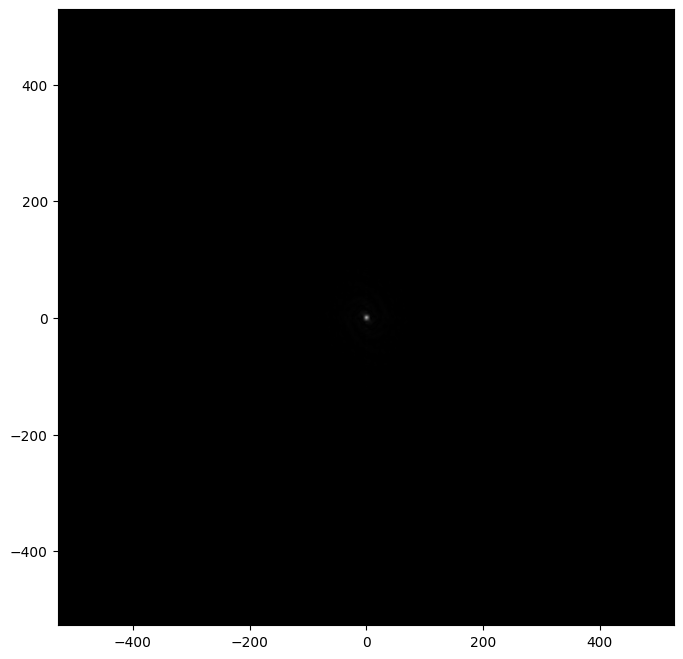

In [17]:
UVPlot = plt.figure(figsize=(8, 8))
UVmax = Npix / 2. / lfac * UVpixsize
UVSh = -UVmax / Npix
FFTtoplot = np.fft.fftshift(modelfft)
toplot = np.abs(FFTtoplot)
mval = np.min(toplot)
Mval = np.max(toplot)
dval = (Mval - mval) / 2.
mymap = plt.gray()
UVPlotFFTPlot = plt.imshow(toplot,
                               cmap=mymap,
                               vmin=0.0,
                               vmax=Mval + dval,
                               picker=5)
plt.setp(UVPlotFFTPlot,
    extent=(-UVmax + UVSh, UVmax + UVSh,
            -UVmax - UVSh, UVmax - UVSh))
plt.show()      